From 이수안 컴퓨터: http://suanlab.com/youtube/ml.html

# 최근접 이웃(K-Nearest Neighbor)

* 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
* 분류와 회귀 모두 지원

![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
plt.style.use(['seaborn-whitegrid'])

In [45]:
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.datasets import load_boston, fetch_california_housing
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import shuffle

In [3]:
seed = 2022
np.random.seed(seed)

## K 최근접 이웃 분류 (Classification)

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [4]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target

In [5]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2, random_state=seed)

In [6]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_train) # scaler fit만 사용.

In [7]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [8]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.9666666666666667
평가 데이터 점수: 1.0


In [9]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.30833333333333335
평가 데이터 점수: 0.43333333333333335


왜 scale했을 경우에 <span style='color:red'> 더 나쁜 결과</span>가 나오는지 확인 필요함.

In [10]:
cross_validate(estimator=KNeighborsClassifier(),
               X=X, y=y,
               cv=5,
               n_jobs=multiprocessing.cpu_count(),
               verbose=1
              )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.0s finished


{'fit_time': array([0.00299835, 0.00299716, 0.00299907, 0.00199795, 0.00299978]),
 'score_time': array([0.00799489, 0.0089941 , 0.00999379, 0.00399613, 0.02998066]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [11]:
param_grid = [{'n_neighbors': [3,5,7],
              'weights':['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [12]:
gs = GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=param_grid,
                  n_jobs=multiprocessing.cpu_count(),
                  verbose=1
                 )

In [13]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=1)

In [14]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7)

In [15]:
gs.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'uniform'}

In [16]:
print("GridSearchCV best score: {}".format(gs.best_score_))

GridSearchCV best score: 0.9800000000000001


In [17]:
def make_meshgrid(x, y, h=0.2): # h: 경계선 세밀도 정도
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [18]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [19]:
iris_comp_df = pd.DataFrame(X_comp)
iris_comp_df['Target'] = y
iris_comp_df.head()

,0,1,Target
0,12.257395,-19.318449,0
1,12.942140,-16.617193,0
2,11.827062,-16.890350,0
3,12.160565,-16.396772,0
4,12.368599,-19.300303,0


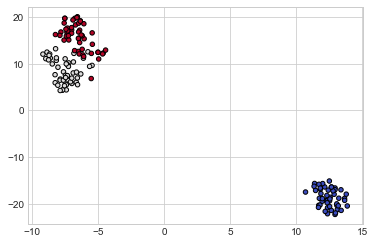

In [20]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k')

In [21]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

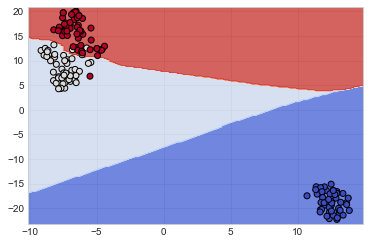

In [22]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

### 유방암 데이터

In [23]:
cancer = load_breast_cancer()

In [24]:
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target

In [25]:
cancer_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [26]:
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [27]:
cancer_train_df = pd.DataFrame(data=X_train, columns=cancer.feature_names)
cancer_train_df['target'] = y_train
cancer_train_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.062846,19.294088,91.534527,647.555385,0.096379,0.104041,0.088112,0.048266,0.180841,0.062771,...,25.696044,106.572967,865.925714,0.132472,0.254359,0.273847,0.114129,0.290234,0.083855,0.635165
std,3.450257,4.203790,23.831936,343.109583,0.013989,0.052810,0.079375,0.038224,0.026861,0.006801,...,5.946745,32.620063,544.879558,0.023123,0.158810,0.212275,0.065184,0.063207,0.018150,0.481914
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.120300,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.695000,16.335000,75.015000,419.250000,0.086650,0.065885,0.028190,0.020125,0.161850,0.057885,...,21.325000,84.035000,513.950000,0.116950,0.142350,0.109000,0.065080,0.249400,0.071645,0.000000
50%,13.270000,18.870000,86.180000,546.300000,0.096460,0.094450,0.061260,0.032790,0.179100,0.061830,...,25.400000,97.820000,686.600000,0.131300,0.216700,0.226700,0.098510,0.280900,0.080040,1.000000
75%,15.685000,21.710000,103.500000,760.150000,0.105400,0.129700,0.128250,0.070525,0.195700,0.066120,...,29.690000,123.500000,1027.500000,0.146050,0.328050,0.380250,0.161100,0.317750,0.092045,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,0.290600,0.097440,...,45.410000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [59]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test) 

train data에서 사용된 scale 기준을 X_test에 그대로 사용함 https://sebastianraschka.com/faq/docs/scale-training-test.html

In [29]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

print('KNN 학습데이터 점수: {}'.format(model.score(X_train, y_train)))
print('KNN 평가데이터 점수: {}'.format(model.score(X_test, y_test)))

KNN 학습데이터 점수: 0.945054945054945
KNN 평가데이터 점수: 0.9298245614035088


In [61]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

print('KNN 학습데이터 점수: {}'.format(model.score(X_train_scale, y_train)))
print('KNN 평가데이터 점수: {}'.format(model.score(X_test_scale, y_test)))

KNN 학습데이터 점수: 0.971830985915493
KNN 평가데이터 점수: 0.9722222222222222


standard scaling, minmax: 좋아 짐.
https://medium.datadriveninvestor.com/increase-10-accuracy-with-re-scaling-features-in-k-nearest-neighbors-python-code-677d28032a45 <br>
normalization (0~1 사이값으로 변환): KNN 계산 특성(point간의 거리 계산)상 scaling을 하면 당연히 정확도가 줄게 되어 있음.<br>
https://stackoverflow.com/questions/42092448/accuracy-difference-on-normalization-in-knn <br>
https://stackoverflow.com/questions/33858893/accuracy-rate-for-knn-classification-dropped-after-feature-normalization

In [31]:
estimator = make_pipeline(StandardScaler(),
                          KNeighborsClassifier()
                         )

cross_validate(estimator=estimator,
              X=X, y=y, cv=5, n_jobs=multiprocessing.cpu_count(),
              verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00499606, 0.00499725, 0.00499892, 0.00399899, 0.00499821]),
 'score_time': array([0.02098775, 0.02098799, 0.02298689, 0.02598381, 0.01998568]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

In [35]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', KNeighborsClassifier())])

param_grid = [{'model__n_neighbors':[3,5,7],
              'model__weights': ['uniform', 'distance'],
              'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [36]:
gs = GridSearchCV(estimator=pipe,
                 param_grid=param_grid,
                 n_jobs=multiprocessing.cpu_count(),
                 verbose=True)

In [37]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [38]:
print("Best Estimator: {}".format(gs.best_estimator_))
print("Best Parameters: {}".format(gs.best_params_))
print('Best Score: {}, Best Index: {}'.format(gs.best_score_ , gs.best_index_))

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])
Best Parameters: {'model__algorithm': 'ball_tree', 'model__n_neighbors': 7, 'model__weights': 'uniform'}
Best Score: 0.9701288619779538, Best Index: 4


In [39]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [40]:
cancer_comp_df = pd.DataFrame(X_comp)
cancer_comp_df['target'] = y
cancer_comp_df.head()

,0,1,target
0,-3.071758,-32.933582,0
1,-3.710881,-30.185108,0
2,0.058496,-27.057089,0
3,-10.811338,22.604149,0
4,2.375891,-27.621225,0


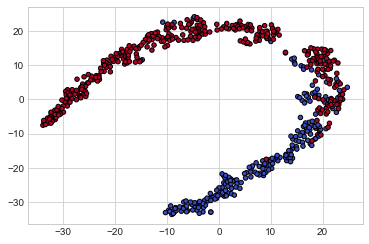

In [42]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [43]:
model = KNeighborsClassifier()
model.fit(X_comp,y)
predict = model.predict(X_comp)

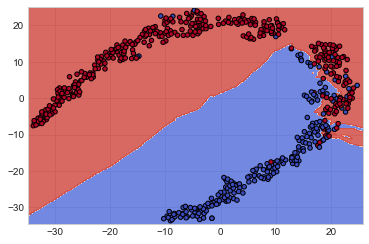

In [44]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

### 와인 데이터

In [46]:
wine = load_wine()

In [48]:
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_df['target'] = wine.target

In [49]:
wine_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [50]:
X, y = wine.data, wine.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [51]:
wine_train_df = pd.DataFrame(data=X_train, columns=wine.feature_names)
wine_train_df['target'] = y_train
wine_train_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,12.967958,2.351549,2.362958,19.535915,98.845070,2.278732,2.032958,0.360423,1.575211,5.056549,0.961239,2.615634,748.556338,0.922535
std,0.815600,1.120145,0.284580,3.303219,13.333313,0.630611,0.999113,0.120495,0.562066,2.339473,0.230854,0.700032,321.872371,0.772524
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.140000,0.410000,1.740000,0.480000,1.270000,278.000000,0.000000
25%,12.332500,1.630000,2.200000,17.425000,88.000000,1.705000,1.227500,0.270000,1.242500,3.255000,0.782500,1.930000,502.500000,0.000000
50%,12.945000,1.880000,2.355000,19.450000,97.000000,2.355000,2.150000,0.335000,1.535000,4.640000,0.980000,2.795000,666.000000,1.000000
75%,13.637500,3.020000,2.560000,21.500000,106.000000,2.787500,2.787500,0.430000,1.915000,6.200000,1.120000,3.170000,988.750000,2.000000
max,14.750000,5.800000,3.230000,28.500000,151.000000,3.880000,5.080000,0.630000,3.580000,13.000000,1.710000,3.820000,1680.000000,2.000000


In [58]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test) 

train data에서 사용된 scale 기준을 X_test에 그대로 사용함 https://sebastianraschka.com/faq/docs/scale-training-test.html

In [53]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

print('KNN 학습데이터 점수: {}'.format(model.score(X_train, y_train)))
print('KNN 평가데이터 점수: {}'.format(model.score(X_test, y_test)))

KNN 학습데이터 점수: 0.8169014084507042
KNN 평가데이터 점수: 0.6666666666666666


In [62]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

print('KNN 학습데이터 점수: {}'.format(model.score(X_train_scale, y_train)))
print('KNN 평가데이터 점수: {}'.format(model.score(X_test_scale, y_test)))

KNN 학습데이터 점수: 0.971830985915493
KNN 평가데이터 점수: 0.9722222222222222


standard scaling, minmax: 좋아 짐.
https://medium.datadriveninvestor.com/increase-10-accuracy-with-re-scaling-features-in-k-nearest-neighbors-python-code-677d28032a45 <br>
normalization (0~1 사이값으로 변환): KNN 계산 특성(point간의 거리 계산)상 scaling을 하면 당연히 정확도가 줄게 되어 있음.<br>
https://stackoverflow.com/questions/42092448/accuracy-difference-on-normalization-in-knn <br>
https://stackoverflow.com/questions/33858893/accuracy-rate-for-knn-classification-dropped-after-feature-normalization

In [63]:
estimator = make_pipeline(StandardScaler(),
                          KNeighborsClassifier()
                         )

cross_validate(estimator=estimator,
              X=X, y=y, cv=5, n_jobs=multiprocessing.cpu_count(),
              verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.8s finished


{'fit_time': array([0.01199269, 0.01199365, 0.01299214, 0.01099324, 0.00699496]),
 'score_time': array([0.0109942 , 0.00899482, 0.00799632, 0.00799417, 0.00499868]),
 'test_score': array([0.94444444, 0.94444444, 0.97222222, 1.        , 0.88571429])}

In [64]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', KNeighborsClassifier())])

param_grid = [{'model__n_neighbors':[3,5,7],
              'model__weights': ['uniform', 'distance'],
              'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [65]:
gs = GridSearchCV(estimator=pipe,
                 param_grid=param_grid,
                 n_jobs=multiprocessing.cpu_count(),
                 verbose=True)

In [66]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [67]:
print("Best Estimator: {}".format(gs.best_estimator_))
print("Best Parameters: {}".format(gs.best_params_))
print('Best Score: {}, Best Index: {}'.format(gs.best_score_ , gs.best_index_))

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])
Best Parameters: {'model__algorithm': 'ball_tree', 'model__n_neighbors': 7, 'model__weights': 'uniform'}
Best Score: 0.9665079365079364, Best Index: 4


In [68]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [69]:
wine_comp_df = pd.DataFrame(X_comp)
wine_comp_df['target'] = y
wine_comp_df.head()

,0,1,target
0,5.836252,9.984283,0
1,6.355986,9.315492,0
2,7.075403,11.877433,0
3,8.265929,14.549829,0
4,1.649179,2.044372,0


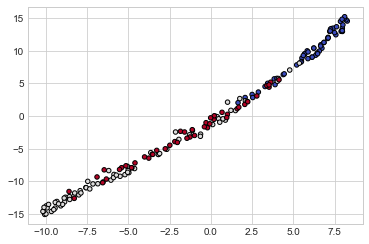

In [70]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [71]:
model = KNeighborsClassifier()
model.fit(X_comp,y)
predict = model.predict(X_comp)

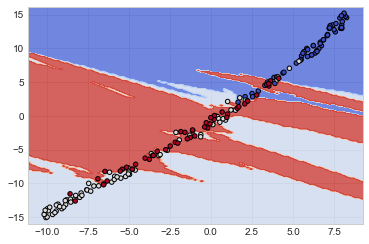

In [72]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

## k 최근접 이웃 회귀

* k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터

In [73]:
boston = load_boston()

In [75]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['TARGET'] = boston.target
boston_df.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [76]:
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [77]:
boston_train_df = pd.DataFrame(X_train, columns=boston.feature_names)
boston_train_df['TARGET'] = y_train

In [78]:
boston_train_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.278691,12.335396,10.731436,0.069307,0.548430,6.328634,66.863861,3.903172,9.039604,398.945545,18.378465,356.825396,12.132129,23.054455
std,8.779204,23.979924,6.910097,0.254290,0.115876,0.682704,28.132572,2.080736,8.430325,164.261554,2.191299,93.680212,6.865907,9.303061
min,0.006320,0.000000,0.460000,0.000000,0.389000,3.863000,6.000000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000,5.000000
25%,0.070197,0.000000,4.930000,0.000000,0.448000,5.918500,42.175000,2.169750,4.000000,277.000000,16.900000,376.745000,6.727500,17.575000
50%,0.222000,0.000000,8.140000,0.000000,0.520000,6.224000,74.350000,3.376500,5.000000,329.500000,18.850000,391.770000,10.685000,21.400000
75%,2.493880,20.000000,18.100000,0.000000,0.614000,6.630250,93.425000,5.234500,8.000000,437.000000,20.200000,396.157500,16.057500,25.125000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [79]:
boston_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     404 non-null    float64
 1   ZN       404 non-null    float64
 2   INDUS    404 non-null    float64
 3   CHAS     404 non-null    float64
 4   NOX      404 non-null    float64
 5   RM       404 non-null    float64
 6   AGE      404 non-null    float64
 7   DIS      404 non-null    float64
 8   RAD      404 non-null    float64
 9   TAX      404 non-null    float64
 10  PTRATIO  404 non-null    float64
 11  B        404 non-null    float64
 12  LSTAT    404 non-null    float64
 13  TARGET   404 non-null    float64
dtypes: float64(14)
memory usage: 44.3 KB


In [81]:
boston_test_df = pd.DataFrame(X_test, columns=boston.feature_names)
boston_test_df['TARGET'] = y_test
boston_test_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,4.939724,7.514706,12.742255,0.068627,0.579510,6.110363,75.351961,3.366767,11.568627,445.039216,18.760784,356.074510,14.716373,20.466667
std,7.757168,20.161656,6.444913,0.254068,0.113061,0.755127,27.308747,2.159418,9.505090,180.694147,2.038984,81.585961,7.841742,8.497237
min,0.009060,0.000000,1.470000,0.000000,0.385000,3.561000,2.900000,1.174200,1.000000,187.000000,13.000000,7.680000,3.730000,6.300000
25%,0.139255,0.000000,7.027500,0.000000,0.489000,5.702000,63.725000,1.789025,4.000000,289.000000,17.800000,359.127500,7.610000,13.950000
50%,0.530950,0.000000,13.905000,0.000000,0.574000,6.169500,87.750000,2.421300,5.000000,394.500000,19.400000,389.750000,14.530000,20.350000
75%,8.224108,0.000000,18.100000,0.000000,0.679000,6.490250,96.000000,4.429675,24.000000,666.000000,20.200000,396.780000,19.670000,24.200000
max,41.529200,95.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,21.200000,396.900000,34.770000,50.000000


In [83]:
scaler =StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [84]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [86]:
print('KNN Regressor 학습데이터 점수: {}'.format(model.score(X_train, y_train)))
print('KNN Regressor 평가데이터 점수: {}'.format(model.score(X_test, y_test)))

KNN Regressor 학습데이터 점수: 0.6826112257519871
KNN Regressor 평가데이터 점수: 0.5251198856177482


In [87]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [89]:
print('KNN Regressor 학습데이터 점수: {}'.format(model.score(X_train_scale, y_train)))
print('KNN Regressor 평가데이터 점수: {}'.format(model.score(X_test_scale, y_test)))

KNN Regressor 학습데이터 점수: 0.8435814899224112
KNN Regressor 평가데이터 점수: 0.7576928097883124


In [90]:
estimator = make_pipeline(StandardScaler(),
                          KNeighborsRegressor()
                         )

cross_validate(estimator=estimator,
              X=X, y=y, cv=5, n_jobs=multiprocessing.cpu_count(),
              verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   13.4s finished


{'fit_time': array([0.01699066, 0.01399159, 0.01499176, 0.00599551, 0.01799107]),
 'score_time': array([0.01399231, 0.00599885, 0.00699568, 0.00399971, 0.01099396]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

In [91]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', KNeighborsRegressor())])

param_grid = [{'model__n_neighbors':[3,5,7],
              'model__weights': ['uniform', 'distance'],
              'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [92]:
gs = GridSearchCV(estimator=pipe,
                 param_grid=param_grid,
                 n_jobs=multiprocessing.cpu_count(),
                 verbose=True)

In [93]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=4,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [94]:
print("Best Estimator: {}".format(gs.best_estimator_))
print("Best Parameters: {}".format(gs.best_params_))
print('Best Score: {}, Best Index: {}'.format(gs.best_score_ , gs.best_index_))

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7,
                                     weights='distance'))])
Best Parameters: {'model__algorithm': 'ball_tree', 'model__n_neighbors': 7, 'model__weights': 'distance'}
Best Score: 0.4973060611762845, Best Index: 5


In [99]:
tsne = TSNE(n_components=1) # class의 구분이 없으므로 1로 지정
X_comp = tsne.fit_transform(X)

In [100]:
boston_comp_df = pd.DataFrame(X_comp)
boston_comp_df['target'] = y
boston_comp_df.head()

,0,target
0,24.028570,24.0
1,40.915710,21.6
2,41.699219,34.7
3,43.156517,33.4
4,43.316521,36.2


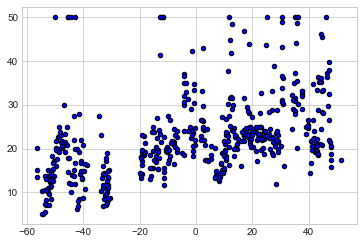

In [101]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [102]:
model = KNeighborsRegressor()
model.fit(X_comp,y)
predict = model.predict(X_comp)

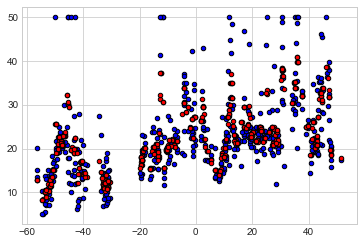

In [104]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k')

### 캘리포니아 주택 가격 데이터

In [105]:
california = fetch_california_housing()

In [106]:
california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df['TARGET'] = california.target
california_df.describe(include='all')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [107]:
X, y = california.data, california.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [108]:
california_train_df = pd.DataFrame(X_train, columns=california.feature_names)
california_train_df['TARGET'] = y_train

In [109]:
california_train_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.881014,28.670422,5.426631,1.095223,1428.172420,2.985153,35.622934,-119.566127,2.076721
std,1.909590,12.598034,2.329441,0.456079,1148.023584,4.807936,2.129164,2.001348,1.157870
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.568425,18.000000,4.437422,1.005376,787.000000,2.433411,33.930000,-121.800000,1.201000
50%,3.541550,29.000000,5.234189,1.048225,1165.500000,2.819512,34.250000,-118.490000,1.804000
75%,4.756825,37.000000,6.056903,1.099417,1729.000000,3.282536,37.710000,-118.010000,2.656000
max,15.000100,52.000000,132.533333,34.066667,35682.000000,599.714286,41.920000,-114.310000,5.000010


In [110]:
california_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      16512 non-null  float64
 1   HouseAge    16512 non-null  float64
 2   AveRooms    16512 non-null  float64
 3   AveBedrms   16512 non-null  float64
 4   Population  16512 non-null  float64
 5   AveOccup    16512 non-null  float64
 6   Latitude    16512 non-null  float64
 7   Longitude   16512 non-null  float64
 8   TARGET      16512 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB


In [111]:
california_test_df = pd.DataFrame(X_test, columns=california.feature_names)
california_test_df['TARGET'] = y_test
california_test_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
count,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,3.829301,28.515746,5.438475,1.102485,1414.694041,3.412663,35.667573,-119.584014,2.035907
std,1.859889,12.536286,2.984016,0.539398,1068.016514,21.138274,2.162784,2.012424,1.137718
min,0.499900,2.000000,1.598131,0.375000,9.000000,1.089268,32.560000,-124.300000,0.149990
25%,2.546900,18.000000,4.456021,1.008231,788.000000,2.415969,33.930000,-121.800000,1.176000
50%,3.516750,29.000000,5.210226,1.050543,1170.000000,2.814580,34.270000,-118.500000,1.776500
75%,4.709675,37.000000,6.038527,1.100000,1699.000000,3.280020,37.732500,-118.000000,2.614250
max,15.000100,52.000000,141.909091,25.636364,12203.000000,1243.333333,41.950000,-114.490000,5.000010


In [112]:
scaler =StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [113]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [114]:
print('KNN Regressor 학습데이터 점수: {}'.format(model.score(X_train, y_train)))
print('KNN Regressor 평가데이터 점수: {}'.format(model.score(X_test, y_test)))

KNN Regressor 학습데이터 점수: 0.45508640482687224
KNN Regressor 평가데이터 점수: 0.15043912207365906


In [115]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [116]:
print('KNN Regressor 학습데이터 점수: {}'.format(model.score(X_train_scale, y_train)))
print('KNN Regressor 평가데이터 점수: {}'.format(model.score(X_test_scale, y_test)))

KNN Regressor 학습데이터 점수: 0.8123200499783254
KNN Regressor 평가데이터 점수: 0.7149704058553223


In [117]:
estimator = make_pipeline(StandardScaler(),
                          KNeighborsRegressor()
                         )

cross_validate(estimator=estimator,
              X=X, y=y, cv=5, n_jobs=multiprocessing.cpu_count(),
              verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.7s finished


{'fit_time': array([0.31885219, 0.29588723, 0.29788613, 0.23595715, 0.22439528]),
 'score_time': array([2.09131002, 1.70849562, 1.82342887, 2.1951654 , 1.63762283]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

In [118]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', KNeighborsRegressor())])

param_grid = [{'model__n_neighbors':[3,5,7],
              'model__weights': ['uniform', 'distance'],
              'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}]

In [119]:
gs = GridSearchCV(estimator=pipe,
                 param_grid=param_grid,
                 n_jobs=multiprocessing.cpu_count(),
                 verbose=True)

In [120]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=4,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [121]:
print("Best Estimator: {}".format(gs.best_estimator_))
print("Best Parameters: {}".format(gs.best_params_))
print('Best Score: {}, Best Index: {}'.format(gs.best_score_ , gs.best_index_))

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7,
                                     weights='distance'))])
Best Parameters: {'model__algorithm': 'ball_tree', 'model__n_neighbors': 7, 'model__weights': 'distance'}
Best Score: 0.5376515274379832, Best Index: 5


In [ ]:
tsne = TSNE(n_components=1) # class의 구분이 없으므로 1로 지정
X_comp = tsne.fit_transform(X)

In [100]:
boston_comp_df = pd.DataFrame(X_comp)
boston_comp_df['target'] = y
boston_comp_df.head()

,0,target
0,24.028570,24.0
1,40.915710,21.6
2,41.699219,34.7
3,43.156517,33.4
4,43.316521,36.2


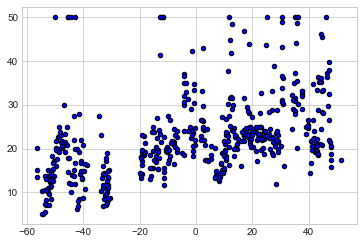

In [101]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [102]:
model = KNeighborsRegressor()
model.fit(X_comp,y)
predict = model.predict(X_comp)

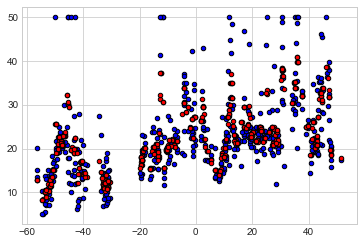

In [104]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k')